In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from DataGenerationCode.DataGeneration import *
from AdditionalFunctionsCode.SolverFunctions import *
from AdditionalFunctionsCode.HelpfulFunctions import *
from TrainingCode.TrainingCode import *
from AutoencoderCode.Autoencoder import *
import os
import time

print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 3050 6GB Laptop GPU


Define Parameters

In [2]:
params = {
    'model': 'lorenz',
    'case': 'synthetic_lorenz',
    'input_dim': 80,
    'latent_dim': 3,
    'poly_order': 2,
    'include_sine': False,
    'fix_coefs': False,
    'svd_dim': 60,
    'delay_embedded': True,
    'scale': True,
    'coefficient_initialization': 'constant',
    "coefficient_initial_value": 1e-2,
    'widths_ratios': [1.0, 0.6],

    # Training
    'max_epochs': 500,
    'patience': 20,
    'batch_size': 2**9,
    'learning_rate': 1e-3,
    "lr_decay": 0.999,

    # Loss Weights
    'loss_weight_rec': 0.3,
    'loss_weight_sindy_z': 0.001,
    'loss_weight_sindy_x': 0.001,
    'loss_weight_sindy_regularization': 1e-5,
    'loss_weight_integral': 0.1,
    'loss_weight_x0': 0.01,
    'loss_weight_layer_l2': 0.0,
    'loss_weight_layer_l1': 0.0,

    # SINDy
    'coefficient_threshold': 1e-5,
    'threshold_frequency': 5,
    'print_frequency': 10,
    'sindy_pert': 0.0,
    'ode_net': False,
    'ode_net_widths': [1.5, 2.0],
    'exact_features': True,
    'use_bias': True,

    # Misc
    'train_ratio': 0.8,
    'data_path': './trained_models',
    'save_checkpoints': False,
    'save_freq': 5,
    'learning_rate_sched': False,
    'use_sindycall': False,
    'sparse_weighting': None,
    'system_coefficients': None
}

Define Lorenz System

In [3]:
lorenz_system = LorenzSystem()
synth_data = SynthData(input_dim=80)
z0 = np.array([1.0, 1.0, 1.0])
synth_data.run_sim(tend=32, dt=0.01, z0=z0, apply_svd=True, svd_dim=params['svd_dim'])

params['dt'] = 0.01
params['tend'] = synth_data.t[-1]
params['n_ics'] = 1



Generating Lorenz system...
self.x (rec_v): (3120, 60)
self.dx: (3120, 60)


Train the Model

In [4]:
params["input_dim"] = params["svd_dim"]
os.makedirs(params['data_path'], exist_ok=True)
start_time = time.time()

trainer = TrainModel(synth_data, params)
trainer.fit()

end_time = time.time()
print(f"\nTraining took {end_time - start_time:.2f} seconds.")

results_202504101047_lorenz_synthetic_lorenz
{'model': 'lorenz', 'case': 'synthetic_lorenz', 'input_dim': 60, 'latent_dim': 3, 'poly_order': 2, 'include_sine': False, 'fix_coefs': False, 'svd_dim': 60, 'delay_embedded': True, 'scale': True, 'coefficient_initialization': 'constant', 'coefficient_initial_value': 0.01, 'widths_ratios': [1.0, 0.6], 'max_epochs': 500, 'patience': 20, 'batch_size': 512, 'learning_rate': 0.001, 'lr_decay': 0.999, 'loss_weight_rec': 0.3, 'loss_weight_sindy_z': 0.001, 'loss_weight_sindy_x': 0.001, 'loss_weight_sindy_regularization': 1e-05, 'loss_weight_integral': 0.1, 'loss_weight_x0': 0.01, 'loss_weight_layer_l2': 0.0, 'loss_weight_layer_l1': 0.0, 'coefficient_threshold': 1e-05, 'threshold_frequency': 5, 'print_frequency': 10, 'sindy_pert': 0.0, 'ode_net': False, 'ode_net_widths': [1.5, 2.0], 'exact_features': True, 'use_bias': True, 'train_ratio': 0.8, 'data_path': './trained_models', 'save_checkpoints': False, 'save_freq': 5, 'learning_rate_sched': False, 'u

Compare Results

Final loss: 3.781742
Epoch where 90% of final loss was first reached: 43
Epoch where 95% of final loss was first reached: 405
Epoch where 99% of final loss was first reached: 463
The Loss at the 300th Epoch is: 4.126545
The Loss at the 500th Epoch is: 3.781742


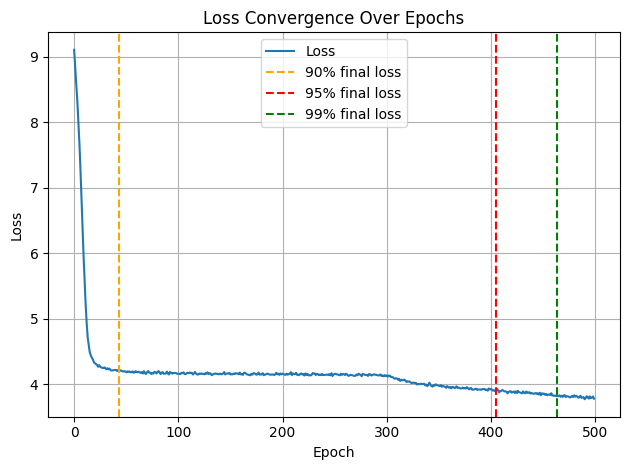

In [5]:
# Convert loss history to numpy array
losses = np.array(trainer.history)
final_loss = losses[-1]

# Define thresholds
threshold_90 = (0.9)**(-1) * final_loss
threshold_97 = 0.97**(-1) * final_loss
threshold_99 = 0.99**(-1) * final_loss

# Find epochs where loss falls below thresholds
epoch_90 = np.argmax(losses <= threshold_90)
epoch_97 = np.argmax(losses <= threshold_97)
epoch_99 = np.argmax(losses <= threshold_99)

print(f"Final loss: {final_loss:.6f}")
print(f"Epoch where 90% of final loss was first reached: {epoch_90}")
print(f"Epoch where 95% of final loss was first reached: {epoch_97}")
print(f"Epoch where 99% of final loss was first reached: {epoch_99}")
print(f"The Loss at the 300th Epoch is: {losses[299]:.6f}")
print(f"The Loss at the 500th Epoch is: {losses[499]:.6f}")

# Plot for intuition
plt.plot(losses, label="Loss")
plt.axvline(epoch_90, color='orange', linestyle='--', label='90% final loss')
plt.axvline(epoch_97, color='red', linestyle='--', label='95% final loss')
plt.axvline(epoch_99, color='green', linestyle='--', label='99% final loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Convergence Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

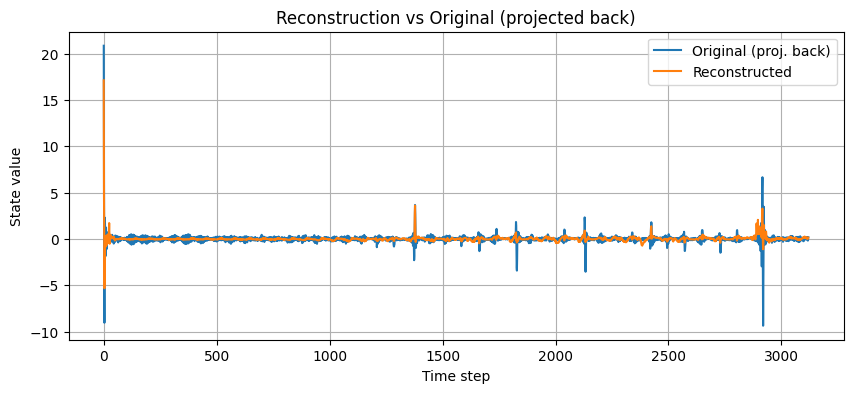

In [6]:
U_p = synth_data.U[:, :params["svd_dim"]]  # (input_dim, svd_dim)

# Get a batch from test set
x_svd = torch.tensor(synth_data.x, dtype=torch.float32).to(trainer.device)
x_reconstructed_svd = trainer.model(x_svd).detach().cpu().numpy()

# Project back to full space
x_original_full = x_svd.cpu().numpy() @ U_p.T
x_reconstructed_full = x_reconstructed_svd @ U_p.T

# Plot a few reconstructed signals (first time series row)
plt.figure(figsize=(10, 4))
plt.plot(x_original_full[:, 0], label="Original (proj. back)")
plt.plot(x_reconstructed_full[:, 0], label="Reconstructed")
plt.legend()
plt.title("Reconstruction vs Original (projected back)")
plt.xlabel("Time step")
plt.ylabel("State value")
plt.grid(True)
plt.show()

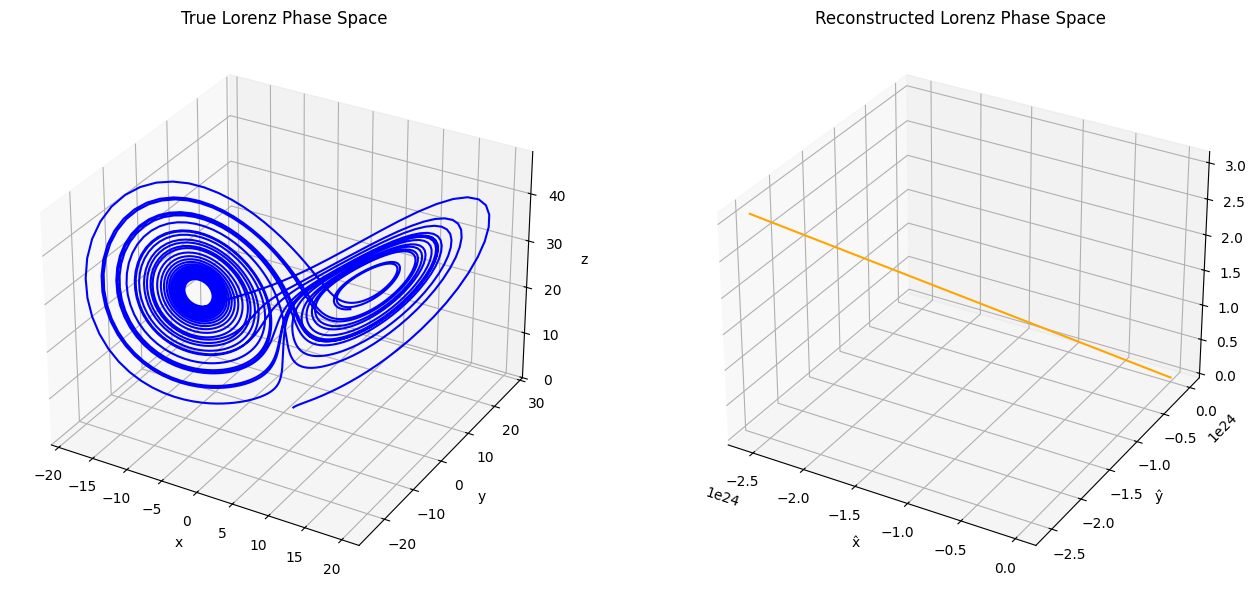

In [10]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# --- Step 1: Get latent representation from SVD input
x_svd = torch.tensor(synth_data.x, dtype=torch.float32).to(trainer.device)
z0 = trainer.model.encoder(x_svd).detach()

# --- Step 2: Integrate latent dynamics using SINDy
dt = trainer.model.dt.item()
n_steps = z0.shape[0]
z_pred = [z0[0]]

for _ in range(1, n_steps):
    z_next = z_pred[-1] + dt * trainer.model.sindy(z_pred[-1].unsqueeze(0))
    z_pred.append(z_next.squeeze(0))

z_pred = torch.stack(z_pred).detach().cpu().numpy()

# --- Step 3: Decode to v̂
v_hat = trainer.model.decoder(torch.tensor(z_pred, dtype=torch.float32).to(trainer.device)).detach().cpu().numpy()

# --- Step 4: Reverse SVD to reconstruct full Lorenz space
U, _, _, _ = get_hankel_svd(synth_data.xorig, reduced_dim=params["svd_dim"])
U_p = U[:, :params["svd_dim"]]
reconstructed_lorenz = v_hat @ U_p.T  # Shape: [N, 3]

# --- Step 5: Ground truth Lorenz data
ground_truth = synth_data.z[:reconstructed_lorenz.shape[0], :]

# --- Step 6: Separate 3D phase space plots
fig = plt.figure(figsize=(14, 6))

# --- Left: Original Lorenz phase space
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot(ground_truth[:, 0], ground_truth[:, 1], ground_truth[:, 2], color='blue', linewidth=1.5)
ax1.set_title("True Lorenz Phase Space")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")

# --- Right: Reconstructed from latent + SINDy
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot(reconstructed_lorenz[:, 0], reconstructed_lorenz[:, 1], reconstructed_lorenz[:, 2], color='orange', linewidth=1.5)
ax2.set_title("Reconstructed Lorenz Phase Space")
ax2.set_xlabel("x̂")
ax2.set_ylabel("ŷ")
ax2.set_zlabel("ẑ")

plt.tight_layout()
plt.show()


[[ 0.0063109  -0.23360768  0.09922547]
 [ 0.08850944  0.04394169 -0.9611049 ]
 [ 0.3575207   0.23430637 -0.7930543 ]
 [ 0.14862652  0.9197416  -0.6169121 ]
 [ 0.00391643 -0.04554255 -0.29495302]
 [-0.26260933  0.37849975  0.6488632 ]
 [ 0.4275214  -0.76432455  0.51537466]
 [-0.21710697  0.04118483  0.3314013 ]
 [ 0.23433296 -0.6467678  -0.24893206]
 [ 0.08062153  1.0938343  -0.79202235]]


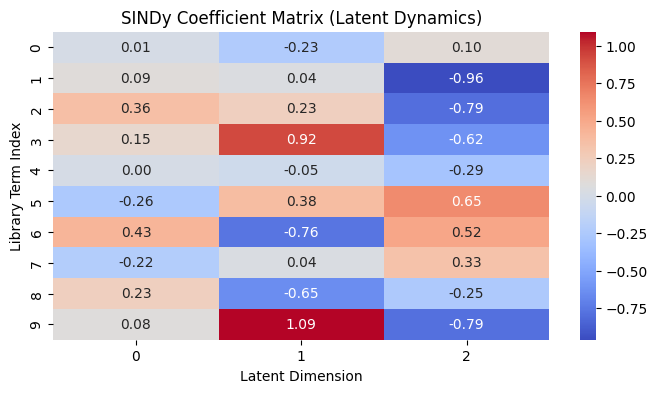

In [8]:
coefs = trainer.model.sindy.coefficients.detach().cpu().numpy()
print(trainer.model.sindy.coefficients.detach().cpu().numpy())
plt.figure(figsize=(8, 4))
sns.heatmap(coefs, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("SINDy Coefficient Matrix (Latent Dynamics)")
plt.xlabel("Latent Dimension")
plt.ylabel("Library Term Index")
plt.show()